 - CODE  
    : IITP_XGBoost
 - DATE  
    : 2023-08-28
 - DESC  
    : df_raw_temp_2023-08-09.csv 데이터를 분석
 - DATA
    기간/간격 : 2017-11-01 01:00:00 ~ 2021-06-30 09:00:00 / 1시간

Ref.  
https://nicola-ml.tistory.com/99

In [29]:
## 필요 Module 설치
# !pip install --upgrade category_encoders
# !pip install gdown
# !pip install kaggle
# !pip install lightgbm
# !pip install xgboost

### 0. Init

In [30]:
## Module Import
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import glob

import os
import warnings
warnings.filterwarnings('ignore')

import time
import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from scipy import stats

## For Model Evaluation
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score   # model.score

# import lightgbm as lgbm
# from lightgbm import LGBMRegressor

import xgboost as xgb
from xgboost import plot_importance, plot_tree, XGBClassifier

## 필요시
# tf.random.set_seed(1234)

In [31]:
# Define data root directory
data_dir = "./DATA/"
print(os.listdir(data_dir))

['ASOS_META_관측지점정보_20230525170502.csv', 'Cheongju_Weekday_2023-07-23.csv', 'Cheongju_Weekend_2023-07-23.csv', 'Data_05-03-01_Intergrated_cj_2023-07-19.csv', 'DATA_2017_2022.csv', 'DATA_2017_2022_ColDel.csv', 'DATA_2020_2022.csv', 'Data_2023-07-19_01-01_Energy_CJ.csv', 'Data_2023-07-19_01-02_Energy_SJ.csv', 'Data_2023-07-19_01_Energy.csv', 'Data_2023-07-19_02_Weather_ASOS.csv', 'Data_2023-07-19_03_Weather_Air.csv', 'Data_2023-07-19_04_Date.csv', 'Data_2023-07-19_05-01-01_Intergrated_cj.csv', 'Data_2023-07-19_05-01-02_Intergrated_sj.csv', 'Data_2023-07-19_05-02-01_Intergrated_cj.csv', 'Data_2023-07-19_05-02-01_Intergrated_sj.csv', 'Data_2023-07-19_05-03-01_Intergrated_cj.csv', 'Data_2023-07-19_05-03-02_Intergrated_sj.csv', 'Data_2023-07-19_05-03_Intergrated.csv', 'Data_2023-07-19_05_Intergrated.csv', 'DATA_CALENDAR.csv', 'DATA_CALENDAR_2nd_intergrated.csv', 'DATA_CALENDAR_Intergrated.csv', 'DATA_CAL_HOLIDAY.csv', 'DATA_CAL_HOLIDAY_24H.csv', 'DATA_CAL_Weather_Energy_2023-06-13.csv', 'DATA

### 1. Data Load

In [32]:
## CSV Export
df_raw = pd.DataFrame()
df_raw = pd.read_csv('./DATA/df_raw_temp_2023-08-09.csv')
# df_raw.to_csv('./DATA/df_raw_temp_2023-08-09.csv', index = False)

In [33]:
df_raw

,HEAT_SELL_DATE,day_of_the_week,rest_YN,code_day_of_the_week,temp_outdoor,temp_ground,temp_dew_point,wind_speed,wind_direction,humidity,...,O3,NO2,PM10,CHEONGJU,Year,Month,Day,Hour,dist_from_holiday,CHEONGJU_1h
0,2010-01-01 00:00:00,Friday,1,5,-9.0,-8.0,-18.0,0.9,320.0,48.0,...,NaN,NaN,NaN,NaN,2010,1,1,0,0,NaN
1,2010-01-01 01:00:00,Friday,1,5,-9.0,-7.0,-17.3,1.1,250.0,51.0,...,0.003,0.033,36.0,178.0,2010,1,1,1,0,NaN
2,2010-01-01 02:00:00,Friday,1,5,-9.3,-6.1,-15.6,0.9,340.0,60.0,...,0.002,0.034,33.0,170.0,2010,1,1,2,0,178.0
3,2010-01-01 03:00:00,Friday,1,5,-9.2,-6.0,-15.5,0.2,0.0,60.0,...,0.001,0.033,37.0,165.0,2010,1,1,3,0,170.0
4,2010-01-01 04:00:00,Friday,1,5,-9.7,-7.5,-15.0,0.5,340.0,65.0,...,0.001,0.030,39.0,161.0,2010,1,1,4,0,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109646,2021-12-31 20:00:00,Friday,0,5,-4.9,-3.0,-17.0,2.1,290.0,38.0,...,0.028,0.016,17.0,217.0,2021,12,31,20,1,215.0
109647,2021-12-31 21:00:00,Friday,0,5,-5.0,-3.5,-17.8,1.1,340.0,36.0,...,0.027,0.017,18.0,221.0,2021,12,31,21,1,217.0
109648,2021-12-31 22:00:00,Friday,0,5,-5.4,-3.8,-17.8,0.1,0.0,37.0,...,0.028,0.015,19.0,217.0,2021,12,31,22,1,221.0
109649,2021-12-31 23:00:00,Friday,0,5,-5.6,-4.2,-17.0,0.9,270.0,40.0,...,0.021,0.021,15.0,214.0,2021,12,31,23,1,217.0


### 2-2. 시각화

In [34]:
## Date의 형식을 datetime으로 변경
date = pd.to_datetime(df_raw['HEAT_SELL_DATE'])
date

0        2010-01-01 00:00:00
1        2010-01-01 01:00:00
2        2010-01-01 02:00:00
3        2010-01-01 03:00:00
4        2010-01-01 04:00:00
                 ...        
109646   2021-12-31 20:00:00
109647   2021-12-31 21:00:00
109648   2021-12-31 22:00:00
109649   2021-12-31 23:00:00
109650   2022-01-01 00:00:00
Name: HEAT_SELL_DATE, Length: 109651, dtype: datetime64[ns]

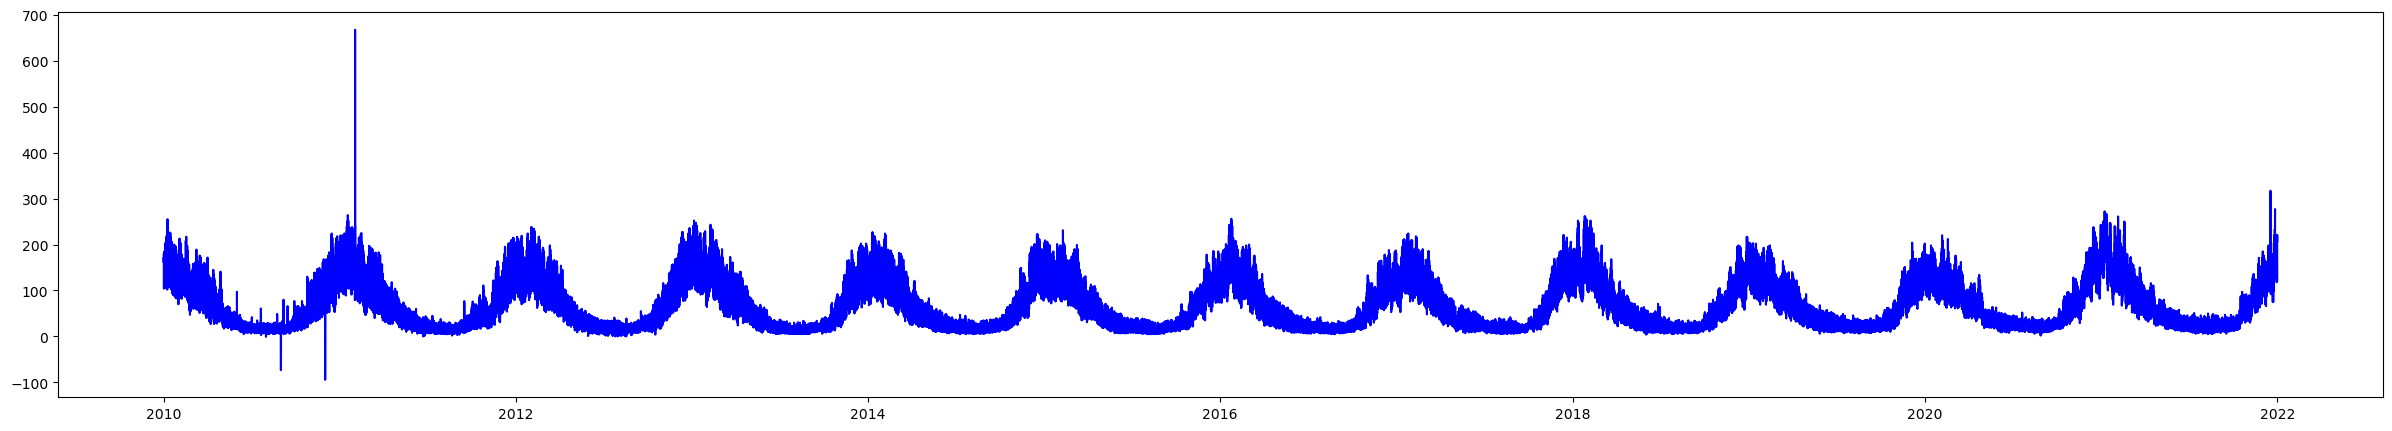

In [35]:
## 시각화
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot(date, df_raw['CHEONGJU'], color='blue')
plt.show()

## 이상치 처리

In [36]:
## 이상치 기준 생성

## Q3 : 100개의 데이터로 가정 시, 25번째로 높은 값에 해당
## Q1 : 100개의 데이터로 가정 시, 75번째로 높은 값에 해당
## IQR : Q3 - Q1의 차이를 의미
## 이상치 : Q3 + 1.5 * IQR보다 높거나 Q1 - 1.5 * IQR보다 낮은 값을 의미

q3_df_raw = df_raw['CHEONGJU'].quantile(0.90)
q1_df_raw = df_raw['CHEONGJU'].quantile(0.25)
iqr_df_raw = q3_df_raw - q1_df_raw
print(q3_df_raw)
print(q1_df_raw)

148.0
22.0


In [37]:
for i in range(0, len(df_raw)):
    outlier_usage = df_raw['CHEONGJU'].iloc[i]
    if ((outlier_usage > (q3_df_raw + 1.5 * iqr_df_raw)) or (outlier_usage < q1_df_raw - 1.5 * iqr_df_raw)):
        print(outlier_usage)
        df_raw['CHEONGJU'].iloc[i] = (df_raw['CHEONGJU'].iloc[i - 1] + df_raw['CHEONGJU'].iloc[i + 1]) / 2
    if outlier_usage < 0:
        print(outlier_usage)
        df_raw['CHEONGJU'].iloc[i] = 0

-0.7
-0.25
-72.3
-72.3
-71.3
-30.65
-72.3
-94.2
667.0


In [38]:
df_raw['CHEONGJU'] = df_raw['CHEONGJU'].interpolate()
df_raw['CHEONGJU'] = df_raw['CHEONGJU'].dropna()

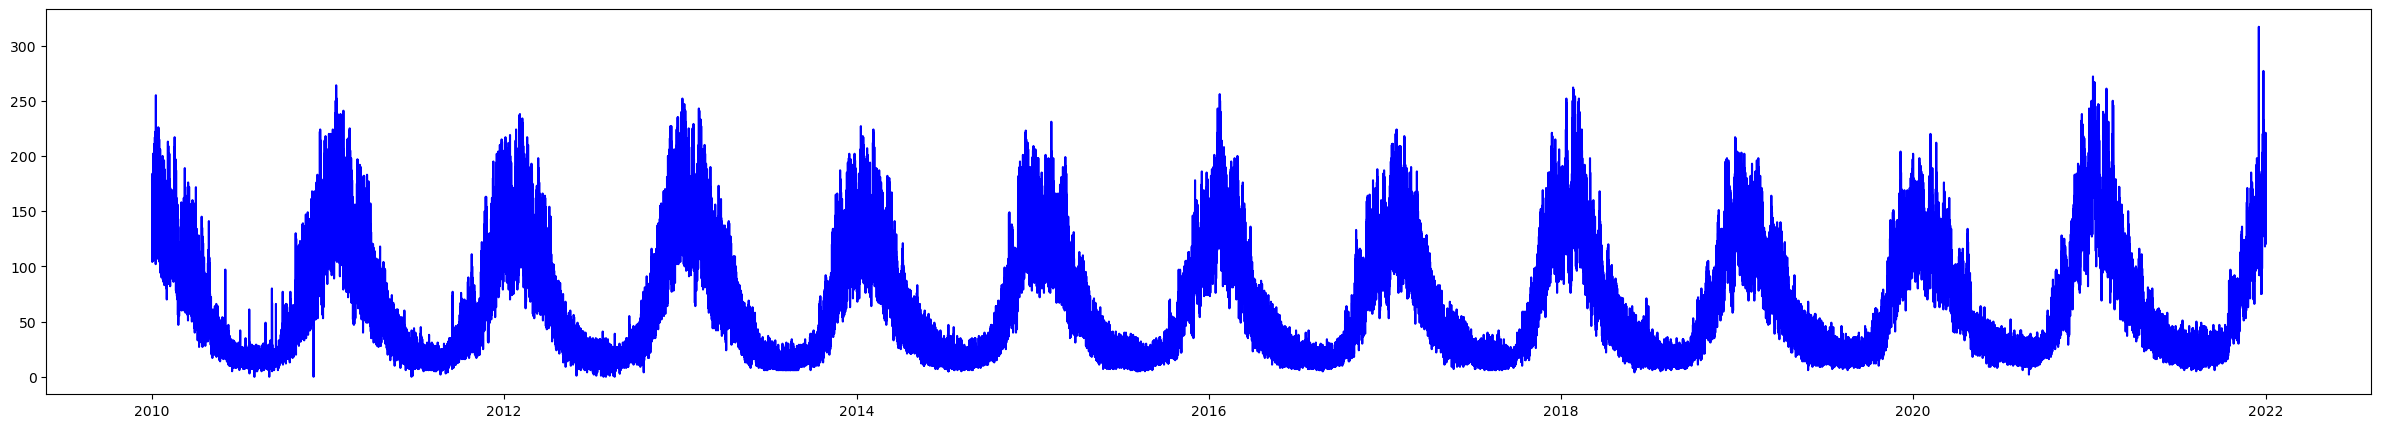

In [39]:
## 시각화
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot(date, df_raw['CHEONGJU'], color='blue')
plt.show()

### 변수형 정리

In [40]:
df_raw_temp = pd.DataFrame(df_raw)

In [41]:
df_raw_temp['HEAT_SELL_DATE'] = pd.to_datetime(df_raw_temp['HEAT_SELL_DATE']).astype('int64')
# df_raw_temp['HEAT_SELL_DATE'] = pd.to_timedelta(df_raw_temp['HEAT_SELL_DATE'])

In [42]:
df_raw_temp[(df_raw_temp['rest_YN'] == 'N')]['rest_YN'] = 0
df_raw_temp[(df_raw_temp['rest_YN'] == 'Y')]['rest_YN'] = 1

for i in range(0, len(df_raw_temp)):
#     df_raw_temp['HEAT_SELL_DATE'][i] = int(i)
    if((str(df_raw_temp['rest_YN'][i]) == 'N') | (df_raw_temp['rest_YN'][i] == '0')):
        df_raw_temp['rest_YN'][i] = 0
    if((str(df_raw_temp['rest_YN'][i]) == 'Y') | (df_raw_temp['rest_YN'][i] == '1')):
        df_raw_temp['rest_YN'][i] = 1

In [43]:
df_raw_temp['rest_YN'] = pd.to_numeric(df_raw_temp['rest_YN'])
df_raw_temp['rest_YN'] = df_raw_temp['rest_YN'].apply(pd.to_numeric)

df_raw_temp['rest_YN'] = df_raw_temp['rest_YN'].astype('int32')

In [44]:
print(df_raw_temp.columns)
print(df_raw_temp.info())

Index(['HEAT_SELL_DATE', 'day_of_the_week', 'rest_YN', 'code_day_of_the_week',
       'temp_outdoor', 'temp_ground', 'temp_dew_point', 'wind_speed',
       'wind_direction', 'humidity', 'rainfall', 'snowfall', 'snowfall_3hr',
       'pressure_vapor', 'pressure_area', 'pressure_sea', 'sunshine',
       'solar_radiation', 'cloud_total', 'cloud_midlow', 'visual_range', 'SO2',
       'CO', 'O3', 'NO2', 'PM10', 'CHEONGJU', 'Year', 'Month', 'Day', 'Hour',
       'dist_from_holiday', 'CHEONGJU_1h'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109651 entries, 0 to 109650
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HEAT_SELL_DATE        109651 non-null  int64  
 1   day_of_the_week       109651 non-null  object 
 2   rest_YN               109651 non-null  int32  
 3   code_day_of_the_week  109651 non-null  int64  
 4   temp_outdoor          109651 non-null  float64
 5   

In [45]:
df_raw_temp

,HEAT_SELL_DATE,day_of_the_week,rest_YN,code_day_of_the_week,temp_outdoor,temp_ground,temp_dew_point,wind_speed,wind_direction,humidity,...,O3,NO2,PM10,CHEONGJU,Year,Month,Day,Hour,dist_from_holiday,CHEONGJU_1h
0,1262304000000000000,Friday,1,5,-9.0,-8.0,-18.0,0.9,320.0,48.0,...,NaN,NaN,NaN,NaN,2010,1,1,0,0,NaN
1,1262307600000000000,Friday,1,5,-9.0,-7.0,-17.3,1.1,250.0,51.0,...,0.003,0.033,36.0,178.0,2010,1,1,1,0,NaN
2,1262311200000000000,Friday,1,5,-9.3,-6.1,-15.6,0.9,340.0,60.0,...,0.002,0.034,33.0,170.0,2010,1,1,2,0,178.0
3,1262314800000000000,Friday,1,5,-9.2,-6.0,-15.5,0.2,0.0,60.0,...,0.001,0.033,37.0,165.0,2010,1,1,3,0,170.0
4,1262318400000000000,Friday,1,5,-9.7,-7.5,-15.0,0.5,340.0,65.0,...,0.001,0.030,39.0,161.0,2010,1,1,4,0,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109646,1640980800000000000,Friday,0,5,-4.9,-3.0,-17.0,2.1,290.0,38.0,...,0.028,0.016,17.0,217.0,2021,12,31,20,1,215.0
109647,1640984400000000000,Friday,0,5,-5.0,-3.5,-17.8,1.1,340.0,36.0,...,0.027,0.017,18.0,221.0,2021,12,31,21,1,217.0
109648,1640988000000000000,Friday,0,5,-5.4,-3.8,-17.8,0.1,0.0,37.0,...,0.028,0.015,19.0,217.0,2021,12,31,22,1,221.0
109649,1640991600000000000,Friday,0,5,-5.6,-4.2,-17.0,0.9,270.0,40.0,...,0.021,0.021,15.0,214.0,2021,12,31,23,1,217.0


#### Data Split (Input / Target)

In [46]:
## ValueError: DataFrame.dtypes for data must be int, float or bool.
## Did not expect the data types in the following fields: DHW_METER_DATE, day_of_the_week, name_of_holiday
## 형식에 맞지 않는 열이 앞의 Preprocessing 단계에서 제거되어야 함.
df_raw_temp = df_raw_temp.drop(['HEAT_SELL_DATE'], axis = 1)
df_raw_temp = df_raw_temp.drop(['day_of_the_week'], axis=1)

## YMD 제거
# df_raw = df_raw.drop(['Year', 'Month', 'Day'], axis=1)

## YD 제거
df_raw_temp = df_raw_temp.drop(['Year', 'Day'], axis=1)

## 그러므로, Split 단계에서 함께 제거하자
# X = df_raw_temp.drop(['CHEONGJU'], axis=1)

# Y = df_raw_temp[['CHEONGJU']]

In [47]:
df_raw_temp.isnull().sum()

rest_YN                 0
code_day_of_the_week    0
temp_outdoor            0
temp_ground             0
temp_dew_point          0
wind_speed              0
wind_direction          0
humidity                0
rainfall                0
snowfall                0
snowfall_3hr            0
pressure_vapor          0
pressure_area           0
pressure_sea            0
sunshine                0
solar_radiation         0
cloud_total             0
cloud_midlow            0
visual_range            0
SO2                     1
CO                      1
O3                      1
NO2                     1
PM10                    1
CHEONGJU                1
Month                   0
Hour                    0
dist_from_holiday       0
CHEONGJU_1h             2
dtype: int64

In [48]:
# df_raw_temp = df_raw_temp.set_index('HEAT_SELL_DATE')
df_raw_temp = df_raw_temp.dropna()

In [49]:
trainSet_Origin, testSet_Origin = train_test_split(df_raw_temp, test_size=0.3, shuffle=False)
print(trainSet_Origin.shape, testSet_Origin.shape)

(76754, 29) (32895, 29)


#### Data Split (Holiday YN)

In [50]:
## TrainSet으로부터 휴일 데이터만을 분리
print(trainSet_Origin.shape)
trainSet = trainSet_Origin

# ## 휴일일 때만
trainSet = trainSet_Origin[(trainSet_Origin['rest_YN'] == 0)]
# trainSet = trainSet.drop(['rest_YN'], axis = 1)
print(trainSet.shape)

# ## Testset으로부터 휴일 데이터만을 분리
# ## ref. https://www.freecodecamp.org/korean/news/untitled/
print(testSet_Origin.shape)
testSet = testSet_Origin

# ## 특정일일 때만
# testSet = testSet_Origin[(testSet_Origin['rest_YN'] == 1)]
# testSet = testSet.drop(['rest_YN'], axis = 1)
print(testSet.shape)

(76754, 29)
(52250, 29)
(32895, 29)
(32895, 29)


In [51]:
trainXX = trainSet.drop(['CHEONGJU'],axis=1)
trainYY = trainSet[['CHEONGJU']]

#valX = val.drop(['INST_F'],axis=1)
#valY = val[['INST_F']]

testXX = testSet.drop(['CHEONGJU'],axis=1)
testYY = testSet[['CHEONGJU']]

In [52]:
trainXXindex = trainXX.index
trainXXcolumns = trainXX.columns

trainYYindex = trainYY.index
trainYYcolumns = trainYY.columns

testXXindex = testXX.index
testXXcolumns = testXX.columns

testYYindex = testYY.index
testYYcolumns = testYY.columns

#valXindex = valX.index
#valYindex = valY.index

#valXcolumns = valX.columns
#valYcolumns = valY.columns

In [53]:
trainXXcolumns

Index(['rest_YN', 'code_day_of_the_week', 'temp_outdoor', 'temp_ground',
       'temp_dew_point', 'wind_speed', 'wind_direction', 'humidity',
       'rainfall', 'snowfall', 'snowfall_3hr', 'pressure_vapor',
       'pressure_area', 'pressure_sea', 'sunshine', 'solar_radiation',
       'cloud_total', 'cloud_midlow', 'visual_range', 'SO2', 'CO', 'O3', 'NO2',
       'PM10', 'Month', 'Hour', 'dist_from_holiday', 'CHEONGJU_1h'],
      dtype='object')

In [54]:
trainYYcolumns

Index(['CHEONGJU'], dtype='object')

In [55]:
d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
# d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
d_trainYY=trainYY

#d_valX=pd.DataFrame(func_valSet, index=valXindex, columns=valXcolumns)
#d_valY=valY

d_testXX=pd.DataFrame(testXX, index=testXXindex, columns=testXXcolumns)
# d_testXX=pd.DataFrame(trainXX, index=testXXindex, columns=testXXcolumns)
d_testYY=testYY

### ML (XGBoost)
https://magoker.tistory.com/106

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

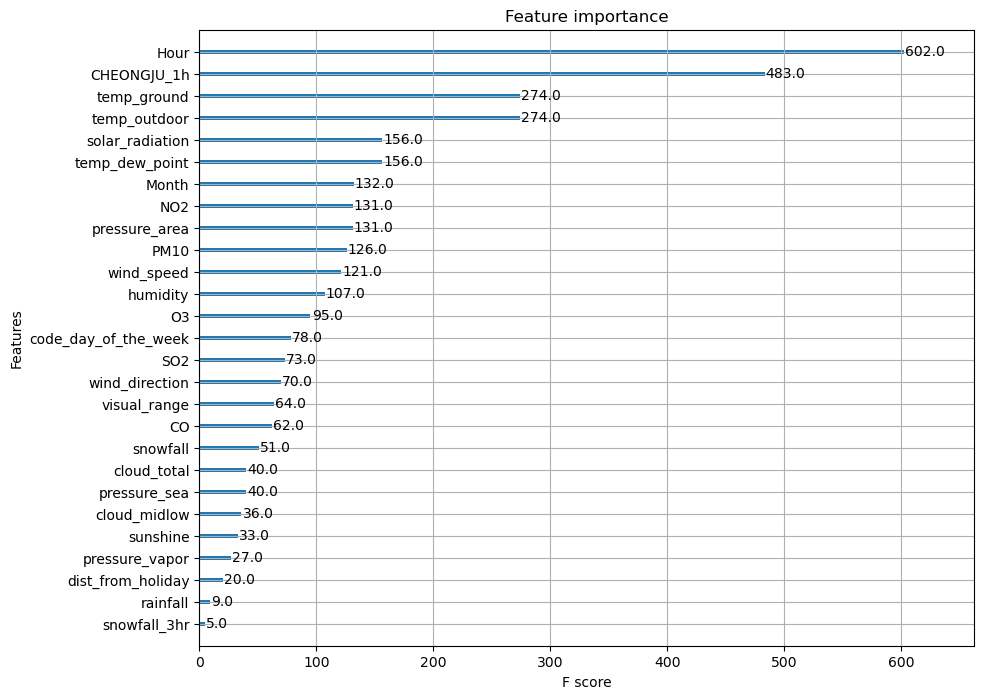

In [56]:
XGB_CJ = xgb.XGBRegressor(n_estimators = 1000)
XGB_CJ.fit(d_trainXX, d_trainYY
           , eval_set=[(d_testXX, d_testYY)]
           , early_stopping_rounds = 50, verbose = False)

## 주요 변수 판단
plot_importance(XGB_CJ)

In [57]:
XGB_pred = XGB_CJ.predict(d_testXX)
XGB_pred = np.reshape(XGB_pred,(-1,1))

In [58]:
d_actual = testYY.to_numpy()
d_actual = np.reshape(d_actual,(-1,1))

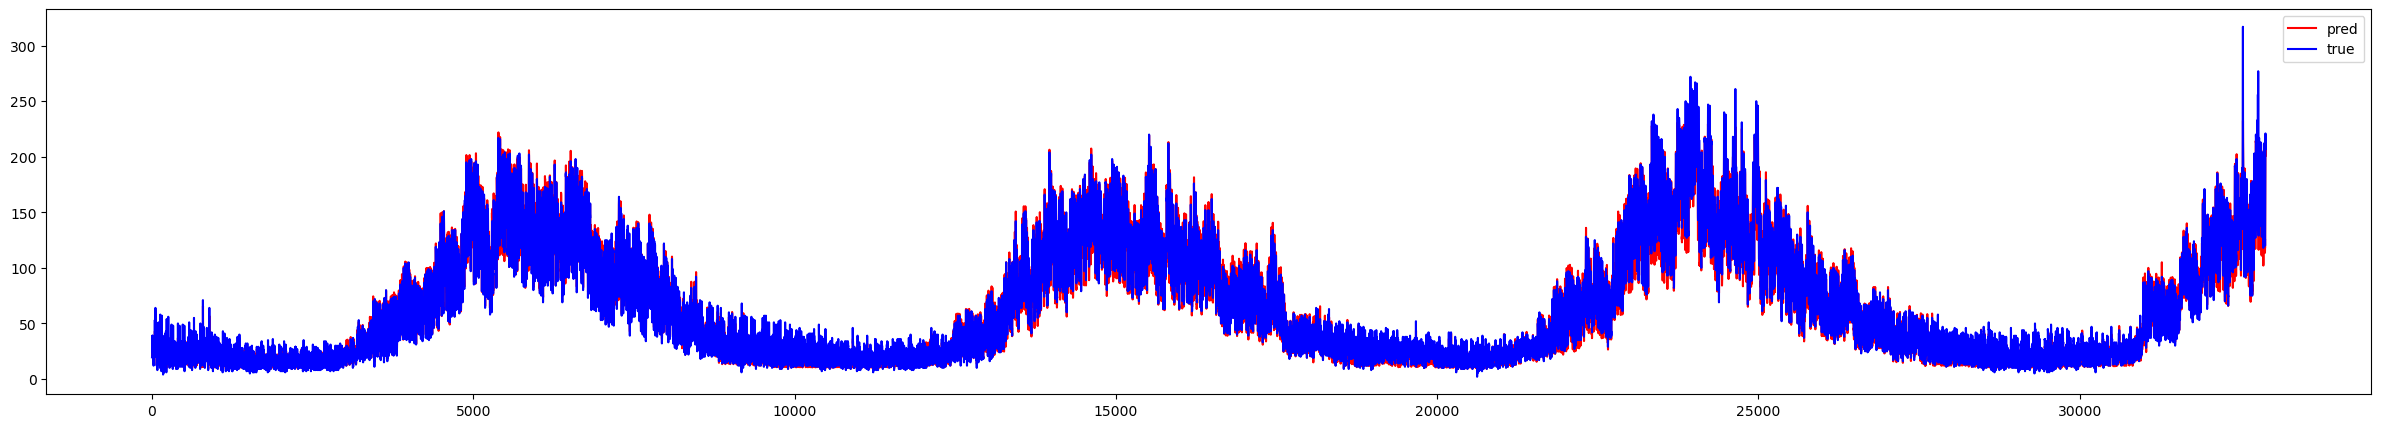

In [59]:
plt.figure(figsize=(30,5))
plt.plot(XGB_pred,color='red',label='pred')
plt.plot(d_actual,color='blue',label='true')
plt.legend()
plt.show()

In [60]:
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(d_actual, XGB_pred))

from sklearn.metrics import mean_absolute_error
print('mean_absolute_error : ', mean_absolute_error(d_actual, XGB_pred))                                      

from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(d_actual, XGB_pred))

from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(d_actual, XGB_pred))

mean_absolute_percentage_error :  0.0953981294767273
mean_absolute_error :  4.407581398751276
mean_squared_error :  39.82486091012076
r2_score :  0.9848631748637591


In [61]:
print(trainSet.shape)
print(testSet.shape)

(52250, 29)
(32895, 29)
